In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import sqlite3

# Set pandas display options untuk menampilkan seluruh konten
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

# df = pd.read_csv('../data/processed/notebooks_viraindo_cleaned.csv')
# df.head(2)

# Membaca file database SQLite untuk verifikasi
conn = sqlite3.connect('../data/database/laptops.db')
query = "SELECT * FROM products_enriched"
df = pd.read_sql_query(query, conn)

df.head(2)


,id,raw_id,raw_product_name,brand,series,processor_detail,processor_category,gpu,gpu_category,ram,storage,display,price_raw,price_in_millions,processed_at,valid_from,valid_to
0,1,10663,"ZYREX CONFIDANTE 2IN1 TOUCH QUALCOMM SNAPDRAGON 850 8CORE 8GB 128GB W10 (Qualcomm Snapdragon 850 8 Core, RAM 8 GB, SSD 128 GB, LED 12.3"" 2K Touchscreen, Win 10 Home)",Zyrex,Confidante,Snapdragon 850,Qualcomm Snapdragon,Unknown Graphics,Other GPU,8GB,128GB,"12.3""",7600000,7.6,2025-11-10 10:32:58.927851,2025-11-10 10:32:58.927867,None
1,2,10662,"Zyrex Blaze Core i5 12450H Memori 32 GB SSD 4 TB Win 11 Pro (Intel Core i5 12450H, RAM 32 GB, SSD 4 TB, Vga Intel UHD Graphics, LED 14 FHD, Windows 11 Profesional) Ready Stock",Zyrex,Blaze,Intel Core I5-12450H,Intel Core i5,Intel UHD Graphics,Intel Integrated Graphics,32GB,4TB,"14""",11400000,11.4,2025-11-10 10:32:58.928129,2025-11-10 10:32:58.928134,None


# EDA

### 1. Price Distribution

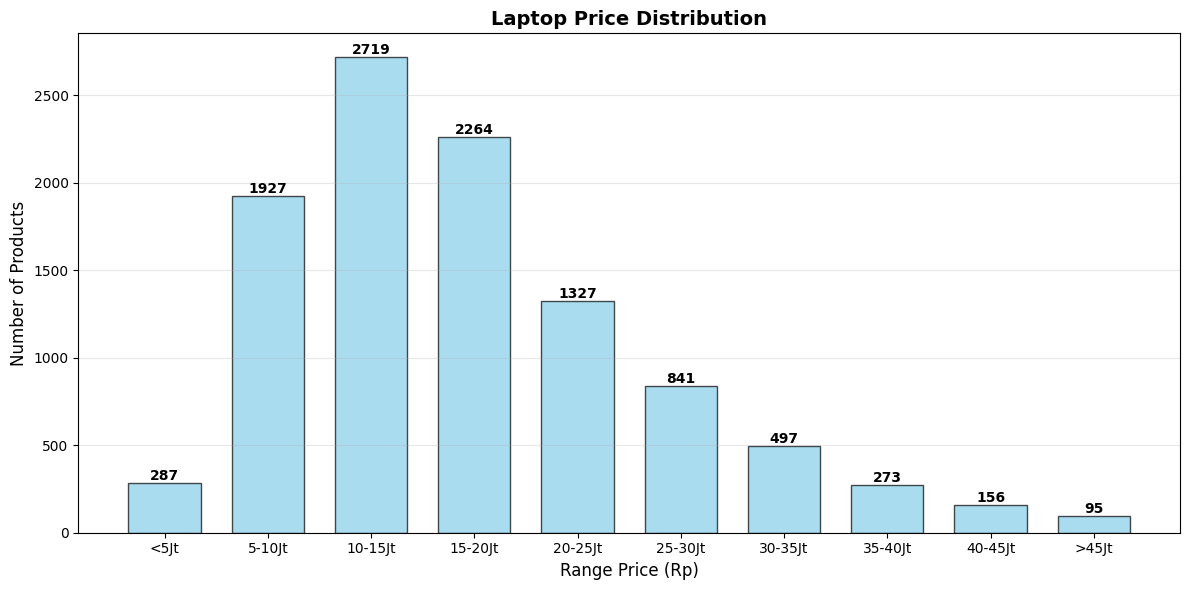

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Convert ke juta dulu
# df['price_in_millions'] = df['price_raw'] / 1000000

# Tentukan range harga yang ingin dipertahankan
min_price = 0
max_price = 50  # sesuai dengan range maksimal Anda
bin_width = 5   # ukuran konsisten setiap bin (5 juta)

# Buat bins dengan ukuran konsisten menggunakan numpy.arange()
bins = np.arange(min_price, max_price + bin_width, bin_width)

# Buat labels yang sesuai dengan bins konsisten
bin_labels = []
for i in range(len(bins)-1):
    if i == 0:
        label = f'<{bins[i+1]:.0f}Jt'
    elif i == len(bins)-2:
        label = f'>{bins[i]:.0f}Jt'
    else:
        label = f'{bins[i]:.0f}-{bins[i+1]:.0f}Jt'
    bin_labels.append(label)

plt.figure(figsize=(12, 6))
n, bins, patches = plt.hist(df['price_in_millions'], bins=bins, alpha=0.7, 
                           color='skyblue', edgecolor='black', rwidth=0.7)

plt.title('Laptop Price Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Range Price (Rp)', fontsize=12)
plt.ylabel('Number of Products', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

# Set custom x-tick labels (posisi di tengah setiap bin)
bin_centers = bins[:-1] + np.diff(bins)/2
plt.xticks(bin_centers, bin_labels)

# Tambahkan value labels di atas setiap bar
for i, (value, patch) in enumerate(zip(n, patches)):
    if value > 0:
        plt.text(patch.get_x() + patch.get_width()/2, value + 0.1, 
                f'{int(value)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/price_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

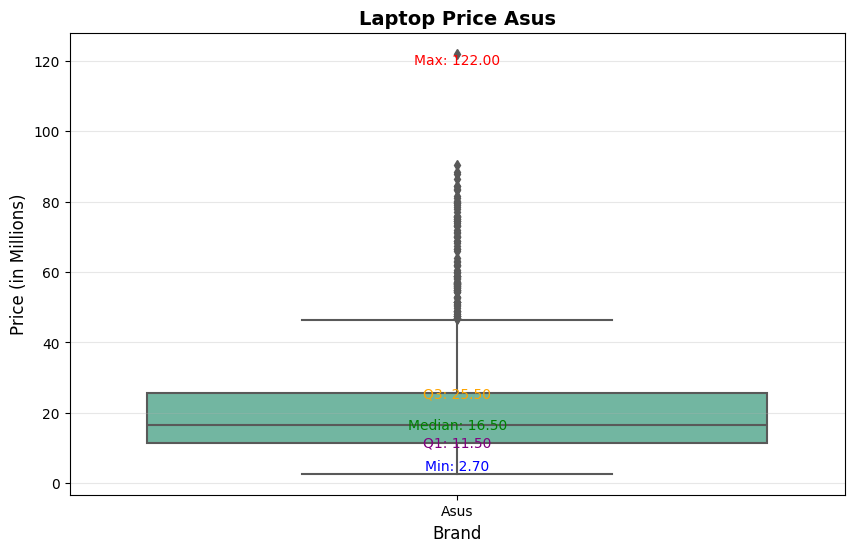

In [3]:
# Membuat boxplot harga laptop berdasarkan brand dan menampilkan detail outlier
asus_df = df[df['brand'] == 'Asus']

# asus_df['price_in_millions'].isnull().sum()
price_stats = asus_df['price_in_millions'].describe()
min_price = price_stats['min']
max_price = price_stats['max']
q1 = price_stats['25%']
q3 = price_stats['75%']
iqr = q3 - q1
median_price = price_stats['50%']

plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='brand', y='price_in_millions', data=asus_df, palette='Set2')
plt.title('Laptop Price Asus', fontsize=14, fontweight='bold')
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Price (in Millions)', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

# Tampilkan nilai statistik pada plot
plt.text(0, min_price, f'Min: {min_price:,.2f}', color='blue', fontsize=10, ha='center', va='bottom')
plt.text(0, max_price, f'Max: {max_price:,.2f}', color='red', fontsize=10, ha='center', va='top')
plt.text(0, median_price, f'Median: {median_price:,.2f}', color='green', fontsize=10, ha='center', va='center')
plt.text(0, q1, f'Q1: {q1:,.2f}', color='purple', fontsize=10, ha='center', va='center')
plt.text(0, q3, f'Q3: {q3:,.2f}', color='orange', fontsize=10, ha='center', va='center')

plt.show()

In [4]:
# Boxplot harga untuk semua brand dengan label statistik menggunakan Plotly
import plotly.graph_objects as go
import plotly.express as px

fig = px.box(df, x='brand', y='price_in_millions', color='brand', points='outliers',
              title='Laptop Price Distribution by Brand (Plotly)',
              labels={'price_in_millions': 'Price (in Millions)', 'brand': 'Brand'})

# Tambahkan label statistik pada setiap brand
brands = df['brand'].unique()
for i, brand in enumerate(brands):
    brand_df = df[df['brand'] == brand]['price_in_millions']
    if len(brand_df) == 0:
        continue
    min_price = brand_df.min()
    max_price = brand_df.max()
    q1 = brand_df.quantile(0.25)
    q3 = brand_df.quantile(0.75)
    median_price = brand_df.median()
    
    # Tambahkan annotation untuk setiap statistik
    # fig.add_annotation(x=brand, y=min_price, text=f'Min: {min_price:,.2f}', showarrow=False, font=dict(color='blue', size=10))
    # fig.add_annotation(x=brand, y=max_price, text=f'Max: {max_price:,.2f}', showarrow=False, font=dict(color='red', size=10))
    # fig.add_annotation(x=brand, y=median_price, text=f'Median: {median_price:,.2f}', showarrow=False, font=dict(color='green', size=10))
    # fig.add_annotation(x=brand, y=q1, text=f'Q1: {q1:,.2f}', showarrow=False, font=dict(color='purple', size=10))
    # fig.add_annotation(x=brand, y=q3, text=f'Q3: {q3:,.2f}', showarrow=False, font=dict(color='orange', size=10))

fig.update_layout(xaxis_tickangle=-45, height=600)
fig.show()

#### Insight
- The Indonesian laptop market is dominated by the 10–20 million rupiah (mid-range) price segment.
- Products under 5 million are very few, indicating a limited but potential ultra-budget market.
- Premium laptops (>25 million) only account for a small portion of the market, suitable for branding rather than volume selling.
- Indonesian consumers are very price-sensitive, tending to look for the "sweet spot" between performance and price.
- The biggest opportunity for local manufacturers is in the low-mid range segment (5-10 million) with added value such as 512GB Storage, 16GB RAM, and good build quality.

### 2. Brand Distribution

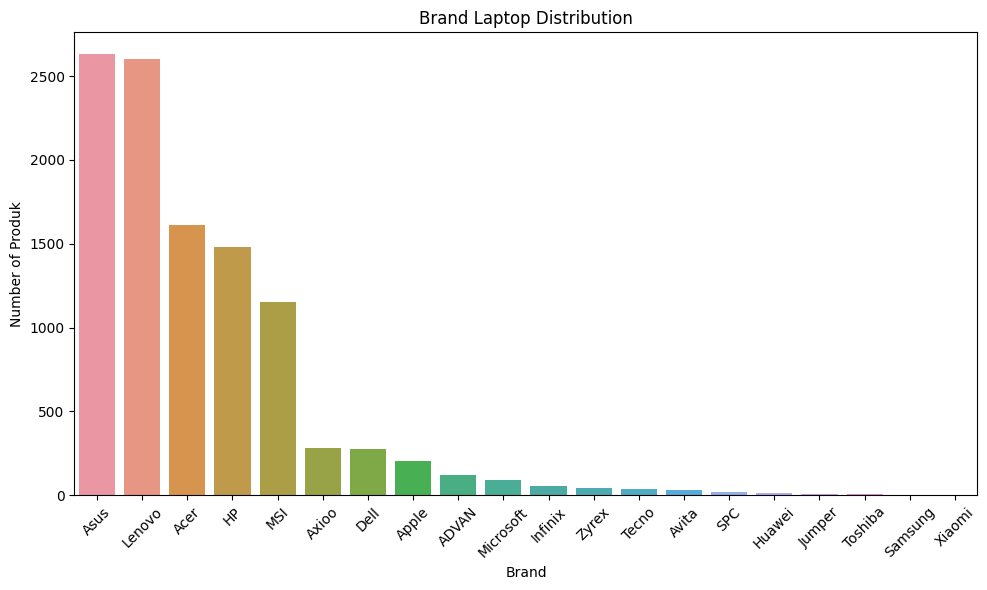

In [5]:
brand_counts = df['brand'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=brand_counts.index, y=brand_counts.values)
plt.title("Brand Laptop Distribution")
plt.ylabel("Number of Produk")
plt.xlabel("Brand")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../results/brand_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


#### Insight
- Lenovo and Asus dominate the Indonesian laptop market with the highest proportion of products (around 50% combined).
- Acer, HP, and MSI round out the top five, playing a strong role in the mid-range and gaming segments.
- Local brands (Axioo, ADVAN, Zyrex) are still small but have great potential in the student and low-budget segments.
- Apple and Dell maintain their premium image with a limited number of products but high prices.
- The market shows fierce competition in the mid-range and a gap in the ultra-budget segment — an opportunity for local brands to expand.

### 3. Processor Category Distribution

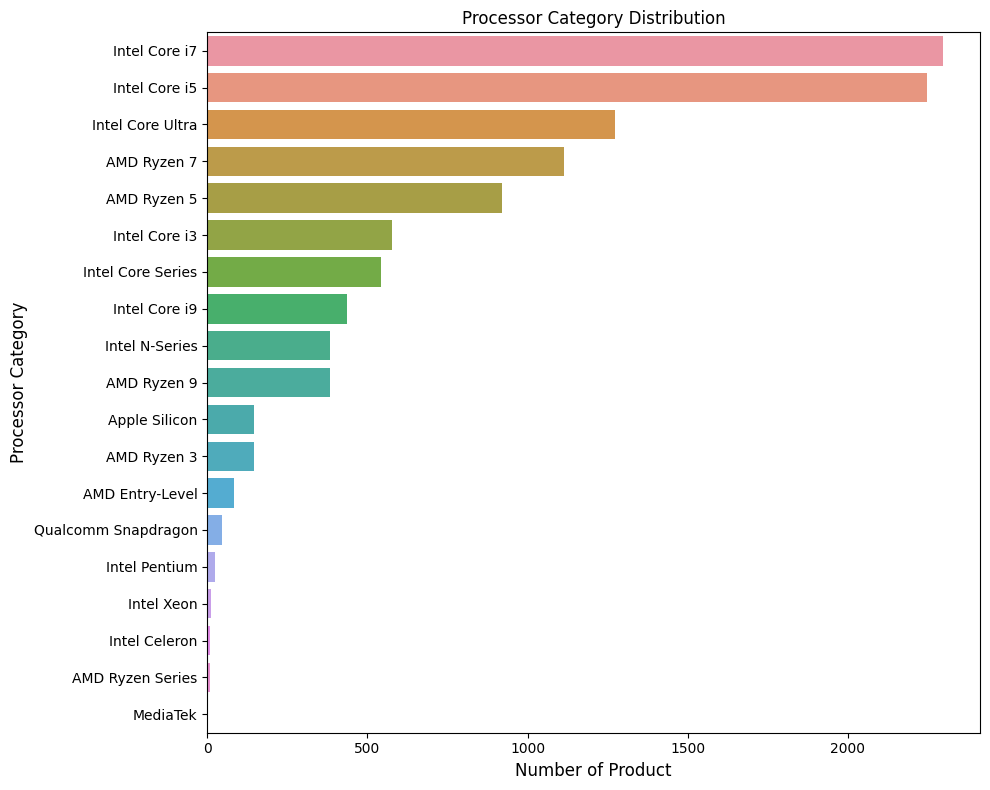

In [6]:
df_processor_filtered = df[df['processor_category'] != 'Unknown Category']
plt.figure(figsize=(10,8))
sns.countplot(y='processor_category', data=df_processor_filtered, order=df_processor_filtered['processor_category'].value_counts().index)
plt.title('Processor Category Distribution')
plt.xlabel('Number of Product', fontsize=12)
plt.ylabel('Processor Category', fontsize=12)
plt.tight_layout()
plt.savefig('../results/processor_category_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

#### Insight
- Intel Core i5 and i7 processors dominate the majority of the laptop market in Indonesia.
- AMD Ryzen 5 & 7 are the main competitors in the mid-high segment with strong multi-core performance.
- Intel Core Ultra is emerging as the future trend in laptops (AI-ready, high efficiency).
- Low-end processors (Celeron, Pentium) have almost disappeared, signaling a shift in the market toward efficiency and high performance.
- Apple Silicon remains exclusive, cementing the MacBook's position in the premium segment.

### 4. Joint Distribution (Brand vs Processor Category)

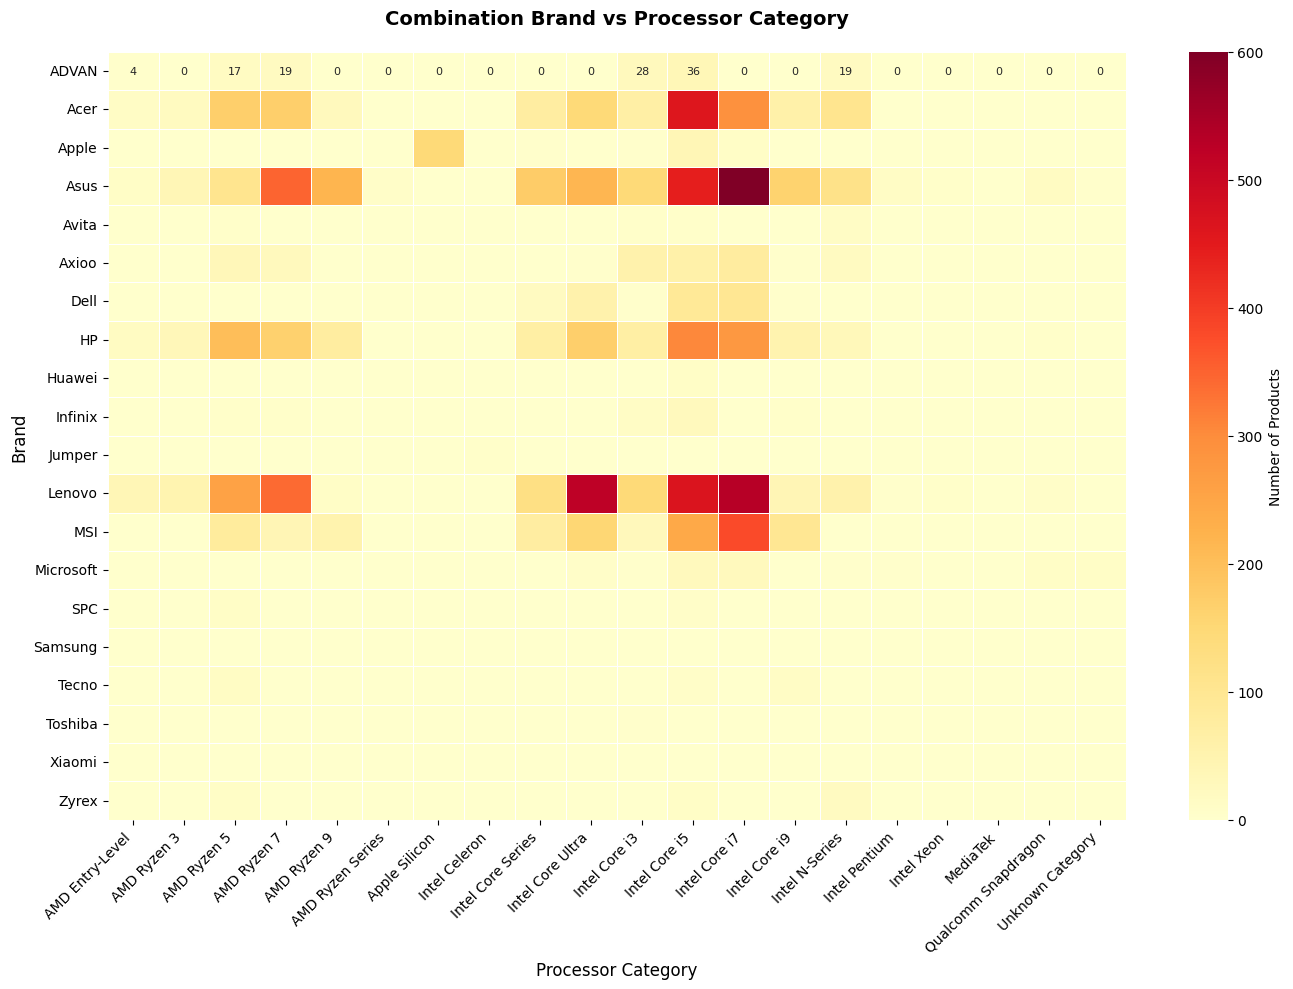

In [7]:
# --- Buat pivot table ---
pivot = pd.crosstab(df['brand'], df['processor_category']).fillna(0)

# --- Visualisasi heatmap sederhana dan jelas ---
plt.figure(figsize=(14, 10))

# --- Membuat heatmap dengan warna yang lebih kontras ---
heatmap = sns.heatmap(
    pivot,
    annot=True,         # tampilkan angka
    fmt='g',            # format angka sebagai integer
    cmap="YlOrRd",      # warna yang lebih kontras
    linewidths=0.5,     # garis pembatas antar sel
    cbar_kws={'label': 'Number of Products'},  # label legend warna
    annot_kws={'size': 8}  # ukuran font untuk angka
)

# --- Styling sederhana dan terbaca ---
plt.title("Combination Brand vs Processor Category", fontsize=14, weight="bold", pad=20)
plt.xlabel("Processor Category", fontsize=12)
plt.ylabel("Brand", fontsize=12)

# Rotasi label agar lebih mudah dibaca
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Sesuaikan layout agar tidak terpotong
plt.tight_layout()

# --- Simpan hasil visualisasi ---
plt.savefig("../results/brand_vs_processor_category_distribution.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

#### Insight
- Lenovo, Asus, and Acer dominate the entire processor spectrum — demonstrating a multi-segment strategy from low-end to premium
- Intel Core i5 and i7 are the most common categories in almost all brands → a strong indicator of Intel's dominance
- HP & MSI perform strongly with Ryzen 5/7 → AMD succeeds in the productivity and gaming segments
- Apple Silicon exclusive to the MacBook line, reinforcing its high-end positioning
- The new Core Ultra trend signals the future direction of AI-ready laptops, with Asus and Lenovo leading the way.


### 5. GPU Category Distribution

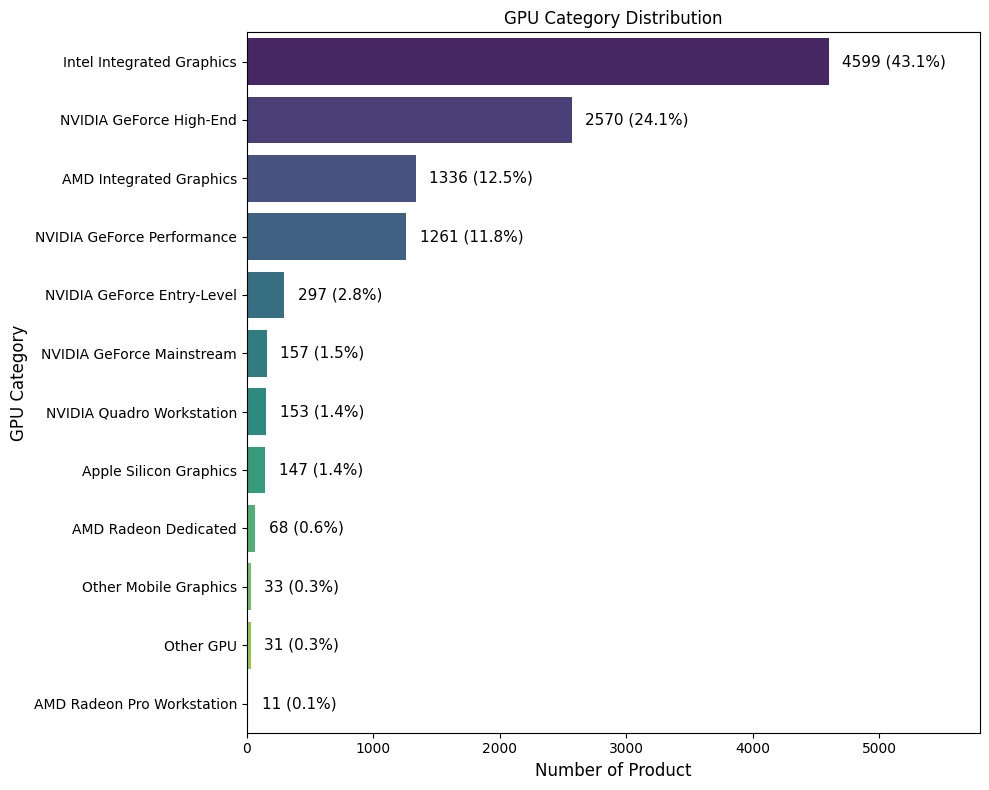

In [8]:
total = len(df)
plt.figure(figsize=(10,8))
ax = sns.countplot(y='gpu_category', data=df, order=df['gpu_category'].value_counts().index, palette='viridis')
plt.title('GPU Category Distribution')
plt.xlabel('Number of Product', fontsize=12)
plt.ylabel('GPU Category', fontsize=12)

# Hide the legend since it's redundant with y-axis labels
plt.legend([],[], frameon=False)

for p in ax.patches:
    width = p.get_width()
    percentage = f'{100 * width / total:.1f}%'
    x = p.get_x() + width + (0.01 * total)
    y = p.get_y() + p.get_height() / 2

    ax.text(x, y, f'{int(width)} ({percentage})', va='center', ha='left', fontsize=11)

plt.xlim(0, plt.xlim()[1] * 1.2)
plt.tight_layout()
plt.savefig('../results/gpu_category_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

### Insight
- 43% of laptops in the Indonesian market use Intel Integrated Graphics, making it the top choice for the productivity segment.
- NVIDIA GeForce (High-End + Performance) dominates nearly 40% of market sales, proving the strong demand for gaming and creative laptops.
- AMD Integrated is available in the mid-range segment, offering efficient performance at a competitive price.
- Exclusive GPUs such as Apple Silicon and NVIDIA Quadro represent a small but stable premium segment.
- This pattern reflects the balanced ecosystem of the Indonesian laptop market between the needs for efficiency, performance, and price.

### 6. RAM Distribution

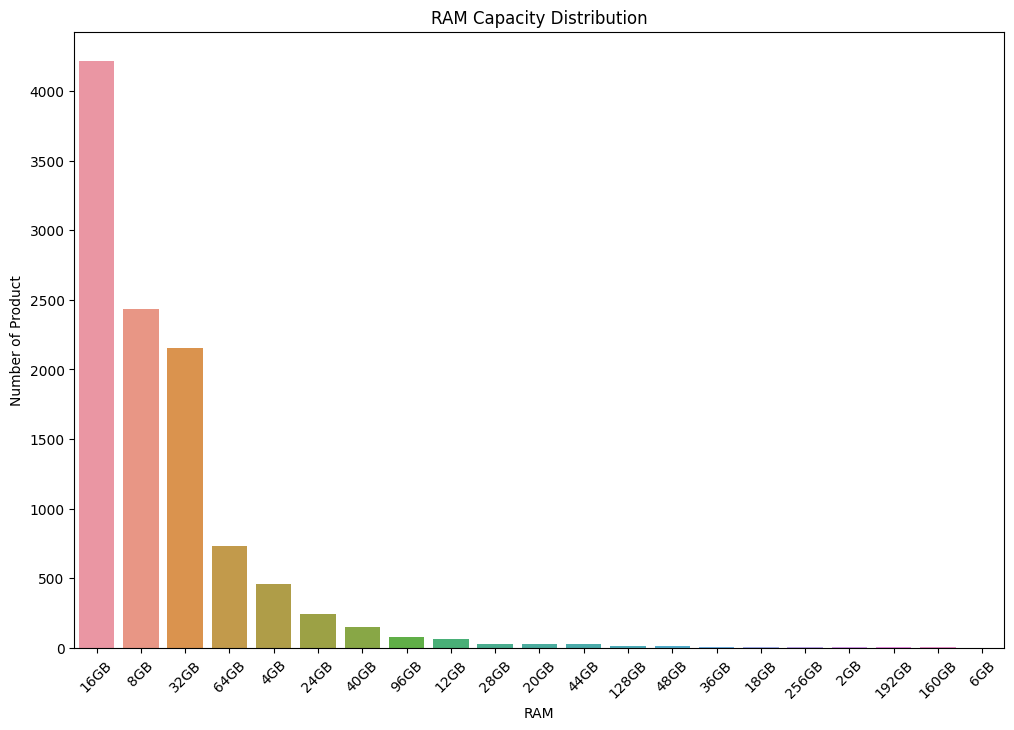

In [9]:
# RAM Distribution Visualization

df_ram_filtered = df[df['ram'] != 'Unknown RAM'] # Filetered RAM with value is 'Unknown RAM'
 
plt.figure(figsize=(12,8))
sns.countplot(data=df_ram_filtered, x='ram', order=df_ram_filtered['ram'].value_counts().index)
plt.title('RAM Capacity Distribution')
plt.xlabel('RAM')
plt.ylabel('Number of Product')
plt.tight_layout
plt.xticks(rotation=45)
plt.savefig('../results/ram_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


In [10]:
df_ram_filtered['ram'].str.strip().value_counts()

ram
16GB     4217
8GB      2431
32GB     2154
64GB      730
4GB       461
24GB      244
40GB      146
96GB       76
12GB       64
28GB       28
20GB       28
44GB       23
128GB      13
48GB       11
36GB        8
18GB        6
256GB       4
2GB         4
192GB       2
160GB       2
6GB         1
Name: count, dtype: int64

### Insight
- 16GB RAM is now the most common and ideal configuration in the Indonesian laptop market.
- 8GB remains popular in the mid-range segment, replacing 4GB as the new standard.
- 32GB–64GB shows strong expansion in the gaming and creative professional markets
- Extreme RAM (≥96GB) is extremely rare and only appears in specialized workstation laptops.
- This shift reflects the increased demand for computing power and multitasking among modern laptop users.

### 7. Storage Distribution

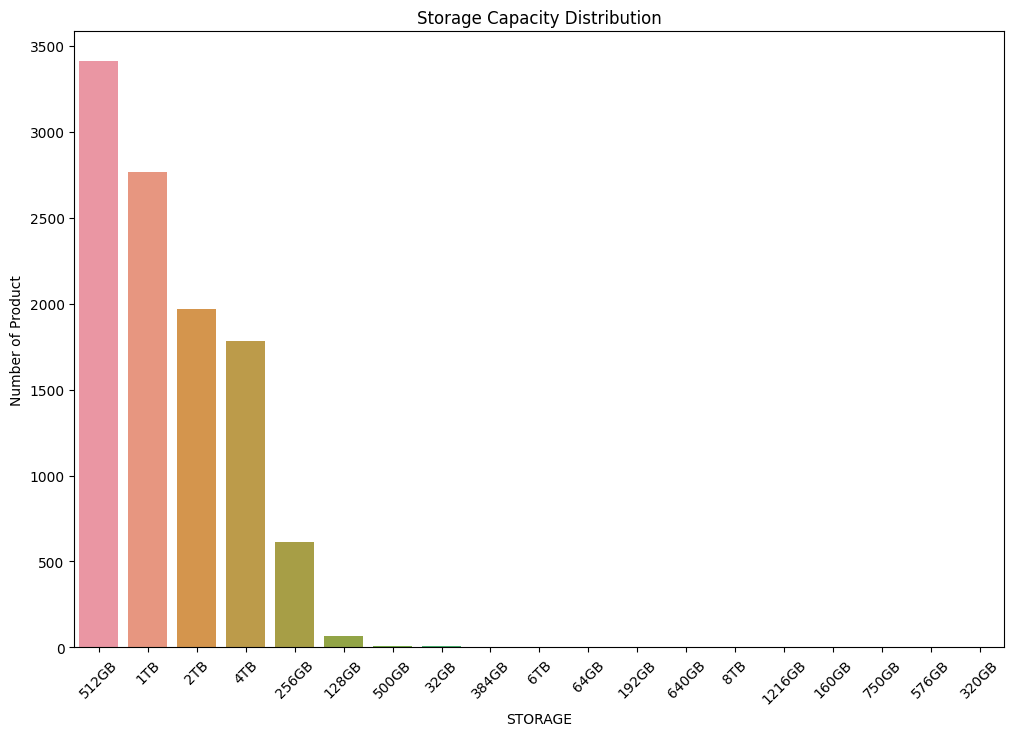

In [11]:
# Storage Distribution Visualization

df_storage_filtered = df[df['storage'] != 'Unknown Storage']

plt.figure(figsize=(12,8))
sns.countplot(data=df_storage_filtered, x='storage', order=df_storage_filtered['storage'].value_counts().index)
plt.title('Storage Capacity Distribution')
plt.xlabel('STORAGE')
plt.ylabel('Number of Product')
plt.tight_layout
plt.xticks(rotation=45)
plt.savefig('../results/storage_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

### Insight
- 512GB storage capacity has become the most dominant capacity and the new standard for modern laptops.
- The 1TB capacity ranks second, making it a favorite choice among gamers and professionals.
- Capacities of 2TB–4TB are becoming common in premium and creator-class laptops.
- Small storage (<256GB) is becoming increasingly rare and is only found in budget laptops.

### 8. Display Size Distribution

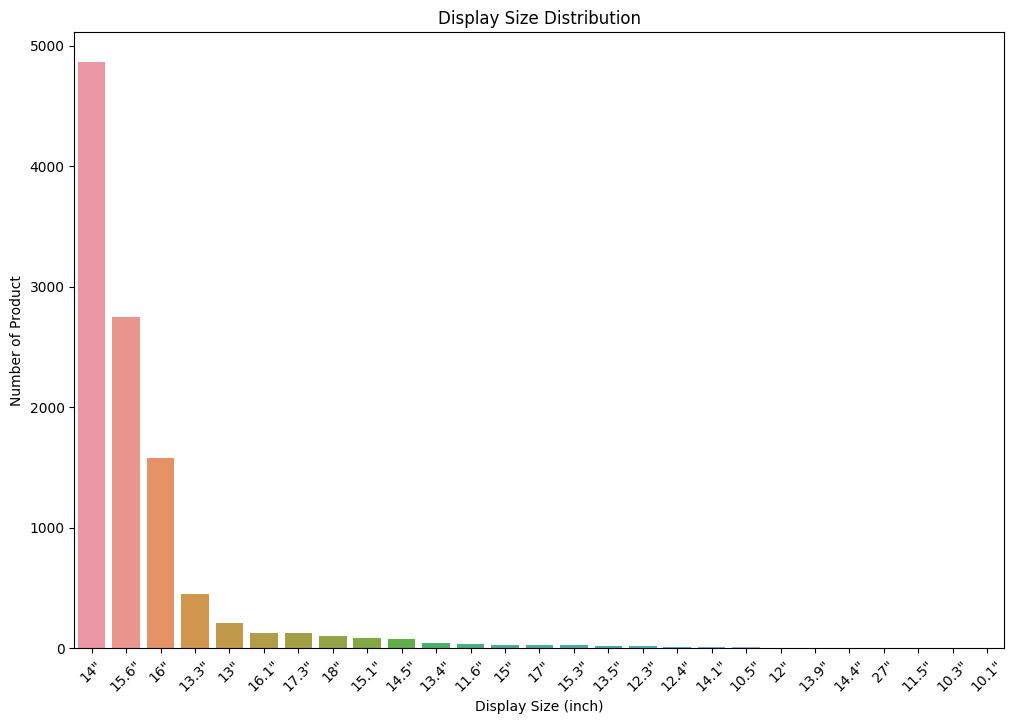

In [12]:
# Display Distribution Visualization

df_display_filtered = df[df['display'] != 'Unknown']

plt.figure(figsize=(12,8))
sns.countplot(data=df_display_filtered, x='display', order=df_display_filtered['display'].value_counts().index)
plt.title('Display Size Distribution')
plt.xlabel('Display Size (inch)')
plt.ylabel('Number of Product')
plt.tight_layout
plt.xticks(rotation=45)
plt.savefig('../results/display_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

#### Insight
- 14 inches is the most dominant screen size and has become the main standard in the modern laptop market.
- 15.6″ still strong in the gaming and multimedia segment.
- 16″ shows a significant growth trend in premium and creative laptops
- Small sizes (<13″) are starting to be abandoned, while large sizes (≥17″) are only relevant in the workstation segment.
- The shift in trends shows that users are oriented towards visual comfort and productivity efficiency rather than just mobility.  

### 9. Price Corelation with RAM by GPU Category

/tmp/ipykernel_35695/3411968174.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



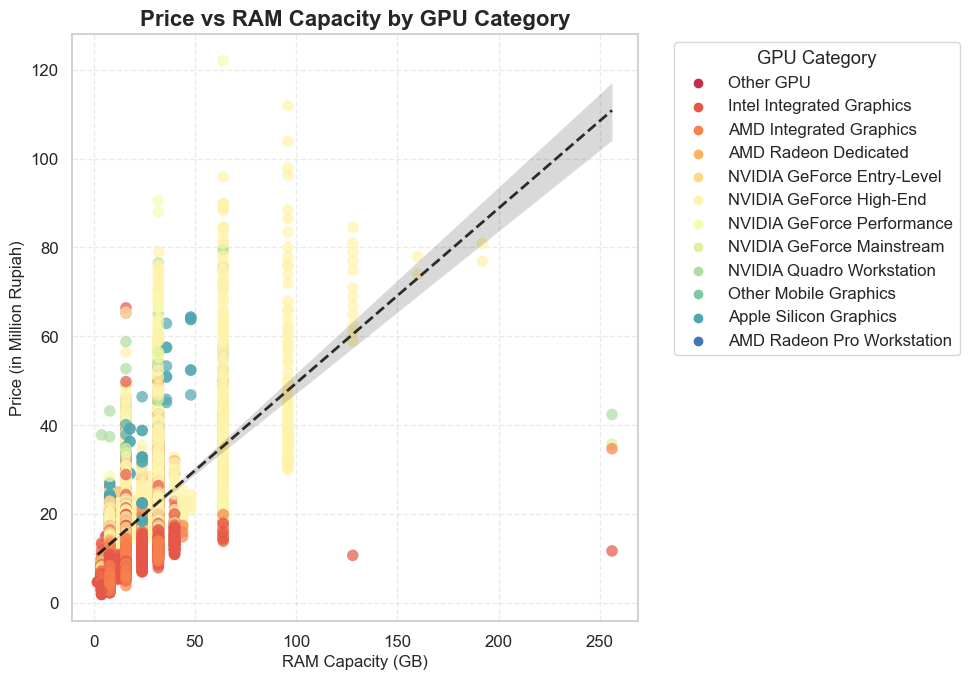

In [13]:
# Konversi nilai RAM ke angka (tanpa 'GB')
df_ram_filtered['ram_gb'] = df_ram_filtered['ram'].str.replace('GB', '', regex=False).astype(int)

# --- Setup Style ---
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10, 7))

# --- Scatterplot dengan Warna GPU Category ---
scatter = sns.scatterplot(
    data=df_ram_filtered,
    x="ram_gb",
    y="price_in_millions",
    hue="gpu_category",
    palette="Spectral",
    alpha=0.7,
    s=70,
    edgecolor="none"
)

# --- Tambahkan Trendline (Hubungan RAM vs Harga) ---
sns.regplot(
    data=df_ram_filtered,
    x="ram_gb",
    y="price_in_millions",
    scatter=False,
    color="black",
    line_kws={"linestyle": "--", "linewidth": 2, "alpha": 0.8}
)

# --- Penyesuaian Label & Tata Letak ---
plt.title("Price vs RAM Capacity by GPU Category", fontsize=16, weight="bold")
plt.xlabel("RAM Capacity (GB)", fontsize=12)
plt.ylabel("Price (in Million Rupiah)", fontsize=12)

# Tata letak legend di luar grafik
plt.legend(title="GPU Category", bbox_to_anchor=(1.05, 1), loc='upper left')

# --- Styling tambahan ---
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()

# --- Simpan hasil visualisasi ---
plt.savefig("../results/visual_price_vs_ram_gpu.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

### Insight
- Laptop prices increase significantly with increased RAM capacity, and are strongly influenced by the type of GPU used.
- Dedicated GPUs (NVIDIA/AMD) come with a price premium even though the RAM capacity is the same, while integrated GPUs are suitable for the low-mid range segment with competitive prices.

### 10. Median Price by Processor Category and GPU Category

/home/wira/Documents/Project/web-scrape/venv/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior



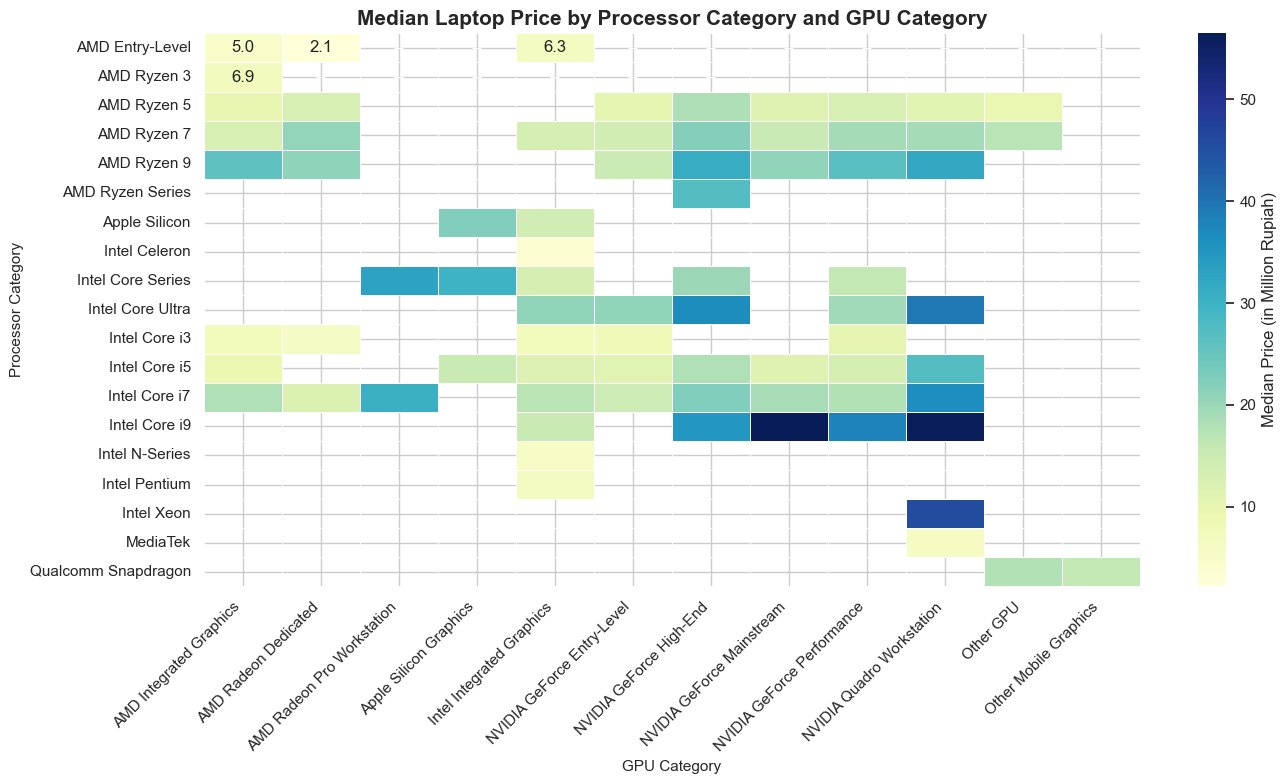

In [14]:
# Memfilter data Processor Category untuk menghapus 'Unknown Category'
df_unknown_filtered = df[df['processor_category'] != 'Unknown Category']
# Membuat pivot table median harga berdasarkan kategori prosesor dan kategori GPU
pivot_table = df_unknown_filtered.pivot_table(index='processor_category', columns='gpu_category', values='price_in_millions', aggfunc='median')

# Setup figure
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid", font_scale=1.0)

# Buat heatmap
sns.heatmap(
    pivot_table,
    annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5,
    cbar_kws={'label': 'Median Price (in Million Rupiah)'}
)

# Styling
plt.title("Median Laptop Price by Processor Category and GPU Category", fontsize=15, weight='bold')
plt.xlabel("GPU Category", fontsize=11)
plt.ylabel("Processor Category", fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Simpan hasil
plt.savefig("../results/heatmap_cpu_gpu_price.png", dpi=300, bbox_inches='tight')
plt.show()

### Insight
- The most expensive laptop on average comes from a combination of Intel Core i9 with NVIDIA GeForce Mainstream GPU, priced at around 56.5M → These are typically high-end gaming laptops or creator laptops with extreme specifications — such as premium displays, large amounts of RAM, and advanced cooling.
- The most premium laptops for professional use are characterized by a combination of Intel Xeon and NVIDIA Quadro Workstation, with a median price of around 45.7M → This combination is commonly used for professional work such as 3D design, CAD, animation, and heavy computing, so it focuses more on stability and durability than style or design.
- Mid-range laptops typically use Intel Core i5, i7, or AMD Ryzen 5–7 processors with GPUs such as NVIDIA GeForce Performance or High-End.
→ Priced between 10 and 30 million rupiah, they are suitable for general users, content creators, and casual gamers who want high performance without paying a premium price.
- Entry-level laptops use processors such as Intel N-Series, Intel Pentium, or AMD Entry-Level with integrated GPUs such as Intel Integrated Graphics. → The median price is around 5–7 million rupiah, ideal for students or users who focus on light activities such as typing and browsing. 
- Apple Silicon laptops (M1, M2, M3) have a median price of around 22 million rupiah. → Although not as extreme as gaming laptops or workstations, Apple remains in the premium consumer category, thanks to the high performance and power efficiency characteristic of its own chips.
- Overall, the higher the class of processor and GPU used, the greater the increase in the median price of the laptop. However, a high price does not always mean "more professional," because some consumer-grade gaming laptops can actually be more expensive than workstations.

In [15]:
# pd.set_option('display.max_columns', None)
df_unknown_display_filtered = df[df['display'] != 'Unknown']
pd.crosstab(df['gpu_category'], df_unknown_display_filtered['display'])
# pd.crosstab(df['gpu_category'], df['display']).plot(kind='bar', figsize=(12, 6))
# plt.title('GPU Category vs Display Size')
# plt.xlabel('GPU Category')
# plt.ylabel('Display Size')
# plt.xticks(rotation=45)
# plt.tight_layout()
# save_path = '/home/wira/Documents/Project/web-scrape/data/gpu_vs_display.png'
# plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
# plt.show()

display,"10.1""","10.3""","10.5""","11.5""","11.6""","12""","12.3""","12.4""","13""","13.3""",...,"15""","15.1""","15.3""","15.6""","16""","16.1""","17""","17.3""","18""","27"""
gpu_category,,,,,,,,,,,,,,,,,,,,,
AMD Integrated Graphics,0,0,0,0,2,0,0,0,7,68,...,0,0,0,281,23,0,2,3,0,0
AMD Radeon Dedicated,0,0,0,0,0,0,0,0,0,0,...,0,0,0,25,12,1,0,0,0,0
AMD Radeon Pro Workstation,0,0,0,0,0,0,0,0,0,0,...,8,0,0,0,3,0,0,0,0,0
Apple Silicon Graphics,0,0,0,0,0,0,0,0,70,0,...,18,0,0,0,28,0,0,0,0,0
Intel Integrated Graphics,1,1,9,2,32,2,18,14,129,360,...,2,0,13,431,152,0,2,1,0,0
NVIDIA GeForce Entry-Level,0,0,0,0,0,0,0,0,0,5,...,0,0,0,82,4,0,0,1,0,0
NVIDIA GeForce High-End,0,0,0,0,0,0,0,0,0,4,...,0,86,13,880,1160,89,13,35,100,4
NVIDIA GeForce Mainstream,0,0,0,0,0,0,0,0,0,0,...,1,0,0,125,0,0,0,11,0,0
NVIDIA GeForce Performance,0,0,0,0,0,0,0,0,2,1,...,0,0,0,860,174,39,1,67,0,0


In [16]:
# import streamlit as st

# st.title('Laptop Market Analysis Dashboard')
# st.sidebar.header('Filters')

# # Interactive filters
# selected_brand = st.sidebar.multiselect('Select Brand', df['brand'].unique())
# price_range = st.sidebar.slider('Price Range',
#                                 min_value=0,
#                                 max_value=50000000,
#                                 value=(0, 20000000))

# # Dynamic Visualizations
# filtered_df = df[(df['brand'].isin(selected_brand)) &
#                  (df['price_raw'].between(price_range[0], price_range[1]))]

# # Show Interactive Charts
# st.plotly_chart(create_interactive_scatter(filtered_df))    

In [17]:
df.head(1)

,id,raw_id,raw_product_name,brand,series,processor_detail,processor_category,gpu,gpu_category,ram,storage,display,price_raw,price_in_millions,processed_at,valid_from,valid_to
0,1,10663,"ZYREX CONFIDANTE 2IN1 TOUCH QUALCOMM SNAPDRAGON 850 8CORE 8GB 128GB W10 (Qualcomm Snapdragon 850 8 Core, RAM 8 GB, SSD 128 GB, LED 12.3"" 2K Touchscreen, Win 10 Home)",Zyrex,Confidante,Snapdragon 850,Qualcomm Snapdragon,Unknown Graphics,Other GPU,8GB,128GB,"12.3""",7600000,7.6,2025-11-10 10:32:58.927851,2025-11-10 10:32:58.927867,None


2025-11-10 13:32:37.998 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-10 13:32:38.484 
  command:

    streamlit run /home/wira/Documents/Project/web-scrape/venv/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-11-10 13:32:38.485 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-10 13:32:38.487 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-10 13:32:38.489 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-10 13:32:38.491 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-10 13:32:38.494 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-10 13:32

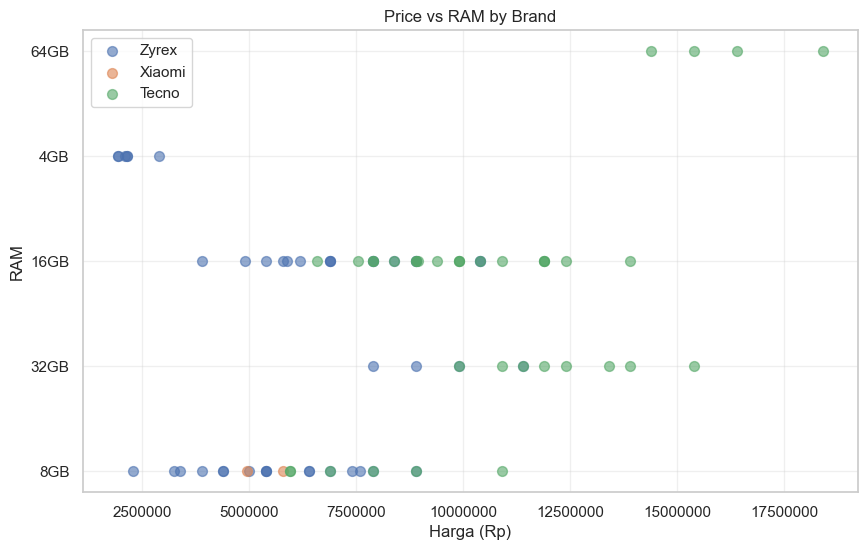

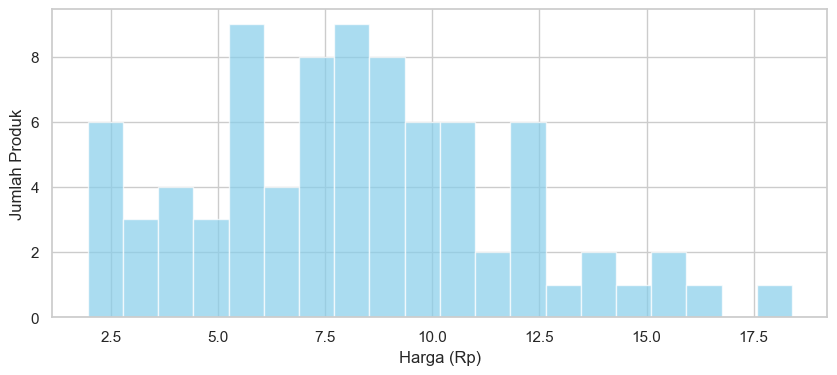

In [18]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_matplotlib_scatter(df):
    """Membuat scatter plot menggunakan matplotlib"""
    if df.empty:
        st.warning("No data available for selected filters")
        return
    
    plt.figure(figsize=(10, 6))
    
    # Buat scatter plot manual
    for brand in df['brand'].unique():
        brand_data = df[df['brand'] == brand]
        plt.scatter(brand_data['price_raw'], brand_data['ram'], 
                   label=brand, alpha=0.6, s=50)
    
    plt.xlabel('Harga (Rp)')
    plt.ylabel('RAM')
    plt.title('Price vs RAM by Brand')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Format x-axis untuk harga
    plt.gca().ticklabel_format(style='plain', axis='x')
    
    return plt

def create_simple_dashboard():
    """Dashboard sederhana tanpa plotly"""
    st.title('Laptop Market Analysis Dashboard')
    st.sidebar.header('Filters')
    
    # Load data Anda di sini
    # df = pd.read_csv('your_data.csv')
    
    # Convert ke juta dulu
    df['price_in_millions'] = df['price_raw'] / 1000000

    # Filters
    selected_brand = st.sidebar.multiselect(
        'Pilih Brand', 
        df['brand'].unique(),
        default=df['brand'].unique()[:3]
    )
    
    price_range = st.sidebar.slider(
        'Range Harga (Rp)', 
        min_value=0, 
        max_value=int(df['price_in_millions'].max()),
        value=(0, int(df['price_in_millions'].quantile(0.8)))
    )
    
    # Filter data
    filtered_df = df[
        (df['brand'].isin(selected_brand)) & 
        (df['price_in_millions'].between(price_range[0], price_range[1]))
    ]
    
    # Metrics
    col1, col2, col3 = st.columns(3)
    with col1:
        st.metric("Total Produk", len(filtered_df))
    with col2:
        st.metric("Harga Rata-rata", f"Rp {filtered_df['price_in_millions'].mean():,.0f}")
    with col3:
        st.metric("Brand Terpilih", len(selected_brand))
    
    # Visualizations dengan matplotlib
    st.subheader("Scatter Plot: Harga vs RAM")
    fig = create_matplotlib_scatter(filtered_df)
    if fig:
        st.pyplot(fig)
    
    # Histogram harga
    st.subheader("Distribusi Harga")
    fig2, ax2 = plt.subplots(figsize=(10, 4))
    ax2.hist(filtered_df['price_in_millions'], bins=20, alpha=0.7, color='skyblue')
    ax2.set_xlabel('Harga (Rp)')
    ax2.set_ylabel('Jumlah Produk')
    ax2.ticklabel_format(style='plain', axis='x')
    st.pyplot(fig2)
    
    # Data table
    st.subheader("Data Filtered")
    st.dataframe(filtered_df[['brand', 'processor_detail', 'ram', 'storage', 'price_in_millions']].head(10))

# Run dashboard
if __name__ == "__main__":
    create_simple_dashboard()